## X-ray Image Analysis and Statistics
This notebook performs a comprehensive analysis of an X-ray image. The steps include loading the image, handling missing values, calculating statistical metrics, and generating various visualizations to understand the pixel intensity distribution.

## 1. Import Necessary Libraries
First, we import all the required libraries for image processing, data manipulation, statistical analysis, and visualization.

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from scipy.interpolate import griddata

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## 2. Define Utility Functions
2.1. Calculate Mode
Calculates the mode (most frequent value) of the pixel intensities in the image.

In [5]:
def calculate_mode(image_array):
    # Flatten the image array and convert to integers
    data = image_array.flatten().astype(int)
    mode_data = Counter(data).most_common(1)
    return mode_data[0][0]


## 2.2. Calculate Skewness
Computes the skewness of the pixel intensity distribution.

In [6]:
def calculate_skewness(pixel_values):
    return stats.skew(pixel_values)


## 2.3. Handle Missing Values
Identifies missing pixel values and fills them using interpolation.

In [7]:
def handle_missing_values(image_array, missing_value=0):
    """
    Identifies missing values in the image and fills them using interpolation.

    Parameters:
    - image_array (numpy.ndarray): The grayscale image array.
    - missing_value (int or float): The pixel intensity value that represents missing data.

    Returns:
    - filled_image (numpy.ndarray): The image array with missing values filled.
    """
    # Create a mask of missing values
    mask = (image_array == missing_value)

    # If there are no missing values, return the original image
    if not np.any(mask):
        print("No missing values detected in the image.")
        return image_array.copy()

    print(f"Detected {np.sum(mask)} missing pixels. Applying interpolation...")

    # Get the coordinates of valid and missing pixels
    coords = np.array(np.nonzero(~mask)).T
    values = image_array[~mask]

    missing_coords = np.array(np.nonzero(mask)).T

    # If there are no valid pixels to interpolate from, return the original image
    if len(coords) == 0:
        print("All pixels are missing. Cannot perform interpolation.")
        return image_array.copy()

    # Perform interpolation using griddata
    interpolated_values = griddata(coords, values, missing_coords, method='linear')

    # In case some values couldn't be interpolated (e.g., missing at borders), use nearest
    nan_mask = np.isnan(interpolated_values)
    if np.any(nan_mask):
        interpolated_values[nan_mask] = griddata(coords, values, missing_coords[nan_mask], method='nearest')

    # Fill the missing pixels with interpolated values
    filled_image = image_array.copy()
    filled_image[mask] = interpolated_values

    print("Interpolation completed.")
    return filled_image


## 3. Main Analysis Workflow
3.1. Load and Display the X-ray Image
We load the X-ray image using OpenCV, convert it to grayscale if necessary, and display the original image.

In [8]:
def load_image(image_path):
    """
    Loads an image from the specified path and converts it to grayscale if it's colored.

    Parameters:
    - image_path (str): The file path to the image.

    Returns:
    - gray_image (numpy.ndarray): The grayscale image array.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to load image at {image_path}. Check the path and try again.")
        return None

    # Convert to grayscale if the image is colored
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()

    return gray_image

def display_image(image, title='Image'):
    """
    Displays a grayscale image using matplotlib.

    Parameters:
    - image (numpy.ndarray): The grayscale image array.
    - title (str): The title of the plot.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


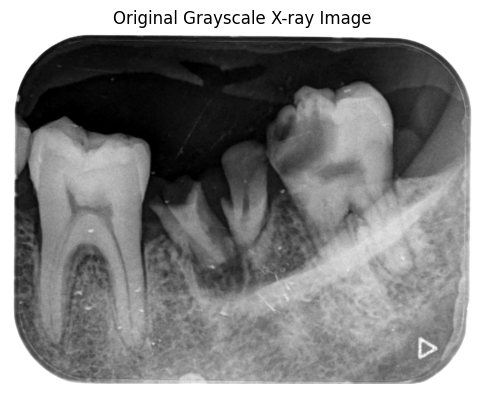

In [9]:
# Define the image path
image_path = r'd:\paper code\Caries\4.bmp'

# Load the image
gray_image = load_image(image_path)

# Proceed only if the image was loaded successfully
if gray_image is not None:
    # Display the original grayscale image
    display_image(gray_image, title='Original Grayscale X-ray Image')


## 3.2. Handle Missing Values
We identify and interpolate missing pixel values in the grayscale image.

Detected 12856 missing pixels. Applying interpolation...
Interpolation completed.


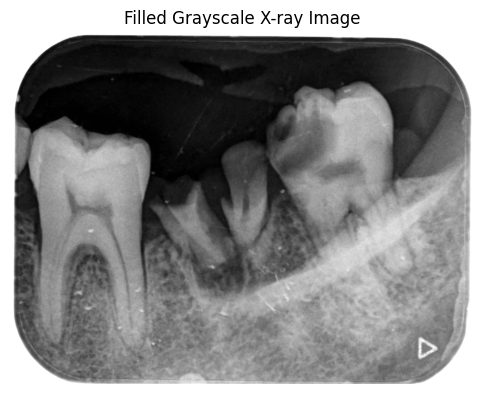

In [10]:
# Define what constitutes a missing value. Here, we assume pixel intensity 0 represents missing data.
missing_value = 0

# Handle missing values by interpolation
filled_gray_image = handle_missing_values(gray_image, missing_value=missing_value)

# Display the filled grayscale image
display_image(filled_gray_image, title='Filled Grayscale X-ray Image')


## 3.3. Calculate Statistical Metrics
Compute mean, median, mode, and skewness of the pixel intensities.

In [11]:
# Flatten the image array for statistical analysis
pixel_values = filled_gray_image.flatten()

# Calculate mean
mean_val = np.mean(pixel_values)

# Calculate median
median_val = np.median(pixel_values)

# Calculate mode
mode_val = calculate_mode(filled_gray_image)

# Calculate skewness
skewness_val = calculate_skewness(pixel_values)

# Display the results
print(f"Mean Pixel Intensity: {mean_val:.2f}")
print(f"Median Pixel Intensity: {median_val}")
print(f"Mode Pixel Intensity: {mode_val}")
print(f"Skewness of Pixel Intensities: {skewness_val:.4f}")


Mean Pixel Intensity: 107.84
Median Pixel Intensity: 118.0
Mode Pixel Intensity: 244
Skewness of Pixel Intensities: 0.0847


## 4. Generate Visualizations
4.1. Histogram of Pixel Intensities
Displays the distribution of pixel intensities with an overlay of the kernel density estimate (KDE) and annotates skewness.

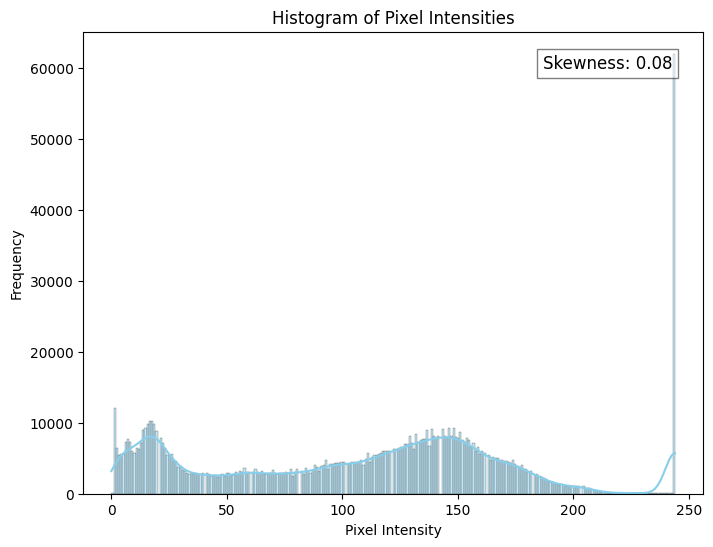

In [12]:
# Create a DataFrame for easier plotting with seaborn
df = pd.DataFrame({'Pixel Intensity': pixel_values})

plt.figure(figsize=(8,6))
sns.histplot(df['Pixel Intensity'], bins=256, kde=True, color='skyblue')
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Annotate skewness on the histogram
plt.text(0.95, 0.95, f"Skewness: {skewness_val:.2f}",
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5))
plt.show()


## 4.2. Boxplot of Pixel Intensities
Provides a summary of the distribution, highlighting the median, quartiles, and potential outliers.

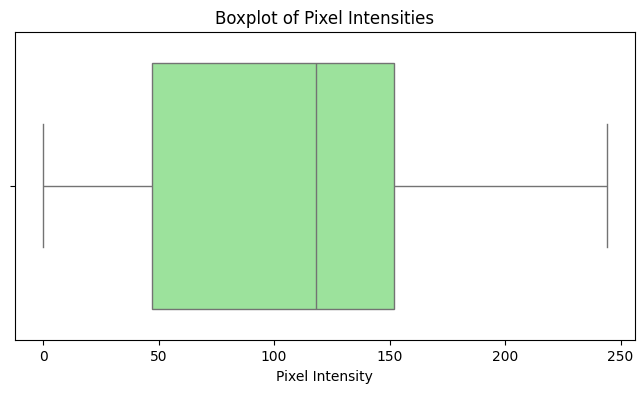

In [13]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Pixel Intensity'], color='lightgreen')
plt.title('Boxplot of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.show()


## 4.3. Q-Q Plot
Assesses whether the pixel intensities follow a normal distribution.

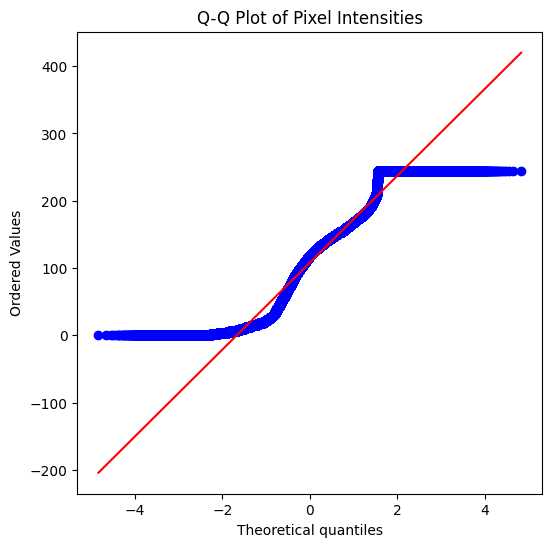

In [14]:
plt.figure(figsize=(6,6))
stats.probplot(df['Pixel Intensity'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Pixel Intensities')
plt.show()


## 4.4. Scatter Plot of Pixel Intensities
Visualizes pixel intensity against pixel index. To avoid overplotting, a sample of points is plotted

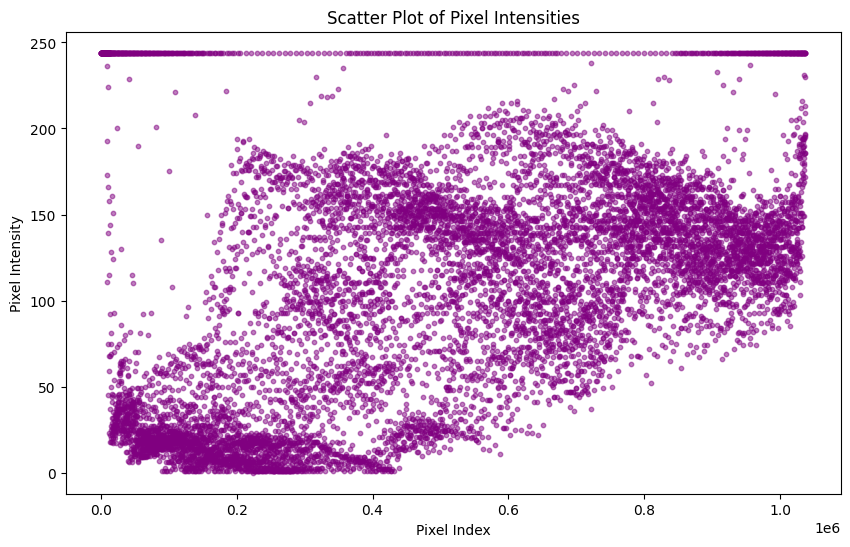

In [15]:
# To create a meaningful scatter plot, we'll plot pixel intensity against pixel index
# For large images, it's better to sample points to avoid overplotting
sample_size = min(10000, len(pixel_values))
indices = np.linspace(0, len(pixel_values)-1, sample_size).astype(int)
sampled_pixels = pixel_values[indices]

plt.figure(figsize=(10,6))
plt.scatter(indices, sampled_pixels, alpha=0.5, s=10, color='purple')
plt.title('Scatter Plot of Pixel Intensities')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Intensity')
plt.show()


## 4.5. Heatmap of Pixel Intensities
Provides a visual representation of the spatial distribution of pixel intensities in the image.

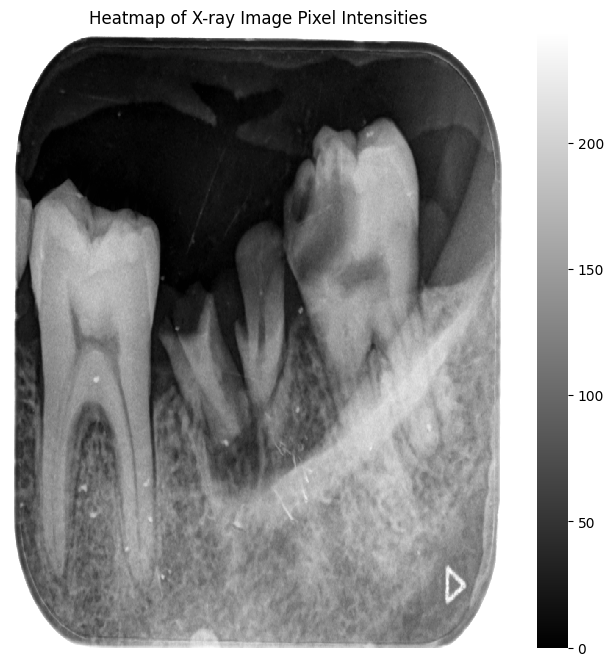

In [16]:
plt.figure(figsize=(8,8))
sns.heatmap(filled_gray_image, cmap='gray', cbar=True)
plt.title('Heatmap of X-ray Image Pixel Intensities')
plt.axis('off')
plt.show()


## Comparative Analysis of Image segmentation Techniques: GMM, K-Means, DBSCAN, and Fuzzy C-Means 

In [17]:
import os
import glob
import threading
import queue
import tkinter as tk
from tkinter import ttk, filedialog, messagebox

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from skfuzzy.cluster import cmeans
from skimage import filters
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

## 1. Image Loading and Preprocessing

Purpose: Ensures all images are standardized in size and color format for consistency in processing.
Why Resize? Clustering and segmentation algorithms are computationally expensive. Resizing reduces complexity without significant loss of feature integrity.

In [18]:
def load_and_preprocess_image(image_path):
    """Load and preprocess an image for segmentation."""
    image = cv2.imread(image_path)  # Load the image in BGR format using OpenCV.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB.
    resized_image = cv2.resize(image, (256, 256))   # Resize the image to a standard size (256x256).
    return image, resized_image  # Return both the original and resized image.


## 2. Feature Extraction 
Purpose: Extracts meaningful features from the image for segmentation.

Color Features: RGB pixel values represent the color information.
Texture Features (LBP): Encodes patterns in local pixel intensity variations, useful for capturing textures.
Edge Features (Sobel): Identifies edges in the image, highlighting regions with high-intensity gradients.
Why Combine Features? Combining different feature types provides a richer representation of the image, improving clustering results.

In [19]:
def extract_features(image):
    """Extract features such as color, texture, and edges from an image."""
    gray_image = rgb2gray(image)  # Convert the RGB image to grayscale.

    # Color features (flattened RGB values)
    color_features = image.reshape(-1, 3)  # Flatten RGB values into a single array.

    # Texture features using Local Binary Patterns (LBP)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    texture_features = lbp.flatten().reshape(-1, 1)  # Flatten and reshape as 1D.

    # Edge features using Sobel filter
    edges = filters.sobel(gray_image)  # Detect edges in the grayscale image.
    edge_features = edges.flatten().reshape(-1, 1)  # Flatten edge map into a single array.

    # Combine all features into a single feature vector
    features = np.hstack((color_features, texture_features, edge_features))
    return features


## 3. Dimensionality Reduction 
Purpose: Simplifies high-dimensional data into a lower-dimensional space for easier clustering.
Why PCA? Reduces computational complexity while retaining the most important variance in the data.


In [20]:
def reduce_dimensionality(features, n_components=2):
    """Reduce feature dimensionality using PCA."""
    pca = PCA(n_components=n_components)  # Reduce to 2 components for clustering
    reduced_features = pca.fit_transform(features)  # Transform features into reduced space.
    return reduced_features


## 4. Clustering Algorithms
Purpose: Assigns each pixel to a cluster based on its features.
Supported Algorithms:
GMM: Models data as a mixture of Gaussian distributions, suitable for smooth segmentation.
K-Means: Groups data by minimizing intra-cluster variance.
DBSCAN: Identifies clusters based on density, handles noise and irregularly shaped clusters well.
Fuzzy C-Means: Allows partial membership of pixels in multiple clusters, capturing ambiguity in boundaries.

In [21]:
def apply_clustering(features, image_shape, algorithm="gmm", n_clusters=2):
    """Apply the specified clustering algorithm to the features."""
    if algorithm == "gmm":
        model = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = model.fit_predict(features)
    elif algorithm == "kmeans":
        model = KMeans(n_clusters=n_clusters, random_state=42)
        labels = model.fit_predict(features)
    elif algorithm == "dbscan":
        model = DBSCAN(eps=0.5, min_samples=10)
        labels = model.fit_predict(features)
    elif algorithm == "fuzzy":
        cntr, u, _, _, _, _, _ = cmeans(
            features.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
        )
        labels = np.argmax(u, axis=0)
    else:
        raise ValueError("Unsupported clustering algorithm.")
    
    # Reshape labels to match the (height, width) shape of the original/resized image
    segmented_image = labels.reshape(image_shape[:2])
    return segmented_image


## 5. Create Color-Coded Segmented Image
Purpose: Converts cluster labels into visually distinct colors for easy interpretation.
Noise Handling: Skips pixels labeled as noise (DBSCAN assigns -1 to noise points).


In [22]:
def create_color_segmented_image(segmented_image):
    """Convert label map into a color-coded segmentation image."""
    unique_labels = np.unique(segmented_image)  # Get unique cluster labels.
    cluster_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Define distinct colors.

    color_segmented = np.zeros((*segmented_image.shape, 3), dtype=np.uint8)  # Initialize color image.
    for label, color in zip(unique_labels, cluster_colors):
        if label != -1:  # Skip noise (label = -1 in DBSCAN).
            color_segmented[segmented_image == label] = (color[:3] * 255).astype(np.uint8)
    return color_segmented


## 6. Segment and Save a Single Image 
Steps:
Load and Preprocess: Read and resize the input image.
Feature Extraction: Extract combined features (color, texture, edges).
Dimensionality Reduction: Use PCA to simplify feature space.
Apply Selected Algorithms: For each selected algorithm:
Perform clustering.
Generate a color-coded segmented image.
Save the result to the specified output folder.
File Naming: Creates descriptive filenames (image_gmm.jpg, image_kmeans.jpg, etc.) for easy identification.

In [23]:
def segment_and_save_image(image_path, output_folder, n_clusters, selected_algos):
    """
    Perform the segmentation on a single image using only the selected algorithms,
    and save results.
    """
    # Load and preprocess
    original_image, resized_image = load_and_preprocess_image(image_path)
    
    # Extract features
    features = extract_features(resized_image)
    
    # PCA dimensionality reduction
    reduced_features = reduce_dimensionality(features, n_components=2)

    # Prepare a base filename for saving outputs
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Apply only the selected algorithms
    if selected_algos.get("gmm", False):
        segmented_gmm = apply_clustering(
            reduced_features, resized_image.shape, algorithm="gmm", n_clusters=n_clusters
        )
        color_gmm = create_color_segmented_image(segmented_gmm)
        cv2.imwrite(
            os.path.join(output_folder, f"{base_name}_gmm.jpg"),
            cv2.cvtColor(color_gmm, cv2.COLOR_RGB2BGR)
        )

    if selected_algos.get("kmeans", False):
        segmented_kmeans = apply_clustering(
            reduced_features, resized_image.shape, algorithm="kmeans", n_clusters=n_clusters
        )
        color_kmeans = create_color_segmented_image(segmented_kmeans)
        cv2.imwrite(
            os.path.join(output_folder, f"{base_name}_kmeans.jpg"),
            cv2.cvtColor(color_kmeans, cv2.COLOR_RGB2BGR)
        )

    if selected_algos.get("dbscan", False):
        segmented_dbscan = apply_clustering(
            reduced_features, resized_image.shape, algorithm="dbscan"
        )
        color_dbscan = create_color_segmented_image(segmented_dbscan)
        cv2.imwrite(
            os.path.join(output_folder, f"{base_name}_dbscan.jpg"),
            cv2.cvtColor(color_dbscan, cv2.COLOR_RGB2BGR)
        )

    if selected_algos.get("fuzzy", False):
        segmented_fuzzy = apply_clustering(
            reduced_features, resized_image.shape, algorithm="fuzzy", n_clusters=n_clusters
        )
        color_fuzzy = create_color_segmented_image(segmented_fuzzy)
        cv2.imwrite(
            os.path.join(output_folder, f"{base_name}_fuzzy.jpg"),
            cv2.cvtColor(color_fuzzy, cv2.COLOR_RGB2BGR)
        )


## 7. Worker Thread Class
The SegmentationWorker is instantiated with:
Input folder path.
Output folder path.
Number of clusters (n_clusters).
Selected algorithms.
Log and progress queues for communication with the main thread (e.g., GUI).
The start() method is called to begin background processing.
During execution:
Images are processed sequentially.
Logs and progress updates are sent to the main thread.
If the user requests a stop, the stop() method is called, and the thread exits gracefully.
Upon completion, a success message is logged, and progress is marked as 100%.


In [24]:
# --------------------------------------------------------------------------------
# 7. Worker Thread Class
# --------------------------------------------------------------------------------
class SegmentationWorker(threading.Thread):
    """
    A threading.Thread class for processing the images in the background.
    Enables non-blocking execution of image segmentation tasks.
    """

    def __init__(self, input_folder, output_folder, n_clusters, selected_algos, log_queue, progress_queue):
        """
        Initializes the worker thread with parameters for segmentation.

        Args:
            input_folder (str): Directory containing images to process.
            output_folder (str): Directory where results will be saved.
            n_clusters (int): Number of clusters for clustering algorithms.
            selected_algos (dict): Dictionary specifying which algorithms to use (e.g., {'gmm': True}).
            log_queue (queue.Queue): Queue for logging messages to the main thread (e.g., GUI).
            progress_queue (queue.Queue): Queue for reporting progress percentage to the main thread.
        """
        super().__init__()
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.n_clusters = n_clusters
        self.selected_algos = selected_algos
        self.log_queue = log_queue
        self.progress_queue = progress_queue
        self._stop_event = threading.Event()  # Event to handle thread stopping gracefully.

    def run(self):
        """
        Main method executed when the thread starts.
        Handles the segmentation process for all images in the input folder.
        """
        try:
            # Ensure the output folder exists; create it if it doesn't
            if not os.path.exists(self.output_folder):
                os.makedirs(self.output_folder)

            # Gather all image files in the input folder with supported extensions
            extensions = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tif", "*.tiff")
            image_paths = []
            for ext in extensions:
                image_paths.extend(glob.glob(os.path.join(self.input_folder, ext)))

            # Get the total number of images for progress tracking
            total_images = len(image_paths)
            if total_images == 0:
                # Log message if no images are found and update progress to 100%
                self.log_queue.put("No images found in the input folder.")
                self.progress_queue.put(100)
                return  # Exit the thread

            self.log_queue.put(f"Found {total_images} images in '{self.input_folder}'.")

            # Process each image
            for idx, img_path in enumerate(image_paths, start=1):
                # Check if the stop event has been triggered
                if self._stop_event.is_set():
                    self.log_queue.put("Segmentation stopped by user.")
                    break  # Exit the loop and terminate processing

                # Log the current image being processed
                self.log_queue.put(f"Processing: {img_path}")
                
                # Perform segmentation and save results
                segment_and_save_image(
                    img_path, 
                    self.output_folder, 
                    self.n_clusters, 
                    self.selected_algos
                )
                
                # Update progress as a percentage of total images processed
                progress_percent = int((idx / total_images) * 100)
                self.progress_queue.put(progress_percent)

            else:
                # If the loop completes without a break, indicate successful completion
                self.log_queue.put("Segmentation completed successfully.")
                self.progress_queue.put(100)

        except Exception as e:
            # Log any errors that occur during execution
            self.log_queue.put(f"Error: {str(e)}")
            self.progress_queue.put(100)  # Mark progress as 100% even in case of an error

    def stop(self):
        """
        Signals the thread to stop execution.
        Sets an internal event that is checked during processing.
        """
        self._stop_event.set()


## 8. Main Tkinter GUI


In [25]:
class SegmentationApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Professional Image Segmentation GUI (Tkinter)")
        self.geometry("950x550")

        # Thread-related attributes
        self.worker_thread = None
        self.log_queue = queue.Queue()
        self.progress_queue = queue.Queue()

        # Algorithms to apply
        self.algorithm_vars = {
            "gmm": tk.BooleanVar(value=True),
            "kmeans": tk.BooleanVar(value=True),
            "dbscan": tk.BooleanVar(value=True),
            "fuzzy": tk.BooleanVar(value=True),
        }

        # Create the UI
        self.create_widgets()
        self.create_menu()

        # Periodically check for messages in queues
        self.check_queues()

    def create_widgets(self):
        """Create and layout all widgets in the main window."""
        # --- Frame for Folder Selection ---
        folder_frame = ttk.LabelFrame(self, text="Folders")
        folder_frame.pack(fill="x", padx=10, pady=5)

        # Input Folder
        ttk.Label(folder_frame, text="Input Folder:").grid(row=0, column=0, padx=5, pady=5, sticky="e")
        self.input_folder_var = tk.StringVar()
        ttk.Entry(folder_frame, textvariable=self.input_folder_var, width=40).grid(row=0, column=1, padx=5, pady=5)
        ttk.Button(folder_frame, text="Browse...", command=self.browse_input_folder).grid(row=0, column=2, padx=5, pady=5)

        # Output Folder
        ttk.Label(folder_frame, text="Output Folder:").grid(row=1, column=0, padx=5, pady=5, sticky="e")
        self.output_folder_var = tk.StringVar()
        ttk.Entry(folder_frame, textvariable=self.output_folder_var, width=40).grid(row=1, column=1, padx=5, pady=5)
        ttk.Button(folder_frame, text="Browse...", command=self.browse_output_folder).grid(row=1, column=2, padx=5, pady=5)

        # --- Frame for Parameters ---
        param_frame = ttk.LabelFrame(self, text="Parameters")
        param_frame.pack(fill="x", padx=10, pady=5)

        # Number of Clusters
        ttk.Label(param_frame, text="Number of Clusters:").grid(row=0, column=0, padx=5, pady=5, sticky="e")
        self.clusters_var = tk.IntVar(value=4)
        self.clusters_spin = ttk.Spinbox(param_frame, from_=2, to=10, textvariable=self.clusters_var, width=5)
        self.clusters_spin.grid(row=0, column=1, padx=5, pady=5, sticky="w")

        # --- Frame for Algorithm Selection ---
        algo_frame = ttk.LabelFrame(self, text="Select Clustering Algorithms")
        algo_frame.pack(fill="x", padx=10, pady=5)

        # Create checkbuttons for each algorithm
        ttk.Checkbutton(algo_frame, text="GMM",    variable=self.algorithm_vars["gmm"]).pack(side="left", padx=10, pady=5)
        ttk.Checkbutton(algo_frame, text="K-Means", variable=self.algorithm_vars["kmeans"]).pack(side="left", padx=10, pady=5)
        ttk.Checkbutton(algo_frame, text="DBSCAN", variable=self.algorithm_vars["dbscan"]).pack(side="left", padx=10, pady=5)
        ttk.Checkbutton(algo_frame, text="Fuzzy",  variable=self.algorithm_vars["fuzzy"]).pack(side="left", padx=10, pady=5)

        # --- Frame for Buttons ---
        button_frame = ttk.Frame(self)
        button_frame.pack(fill="x", padx=10, pady=5)

        self.start_button = ttk.Button(button_frame, text="Start Segmentation", command=self.start_segmentation)
        self.start_button.pack(side="left", padx=5)

        self.stop_button = ttk.Button(button_frame, text="Stop", command=self.stop_segmentation, state="disabled")
        self.stop_button.pack(side="left", padx=5)

        # --- Frame for Log and Progress ---
        log_frame = ttk.LabelFrame(self, text="Log")
        log_frame.pack(fill="both", expand=True, padx=10, pady=5)

        self.log_text = tk.Text(log_frame, wrap="word", height=12)
        self.log_text.pack(fill="both", expand=True, padx=5, pady=5)

        # Progress bar
        self.progress_bar = ttk.Progressbar(log_frame, orient="horizontal", mode="determinate", length=400)
        self.progress_bar.pack(pady=5)

    def create_menu(self):
        """Create a basic menu bar."""
        menubar = tk.Menu(self)
        file_menu = tk.Menu(menubar, tearoff=0)
        file_menu.add_command(label="Exit", command=self.on_exit)
        menubar.add_cascade(label="File", menu=file_menu)
        self.config(menu=menubar)

    def browse_input_folder(self):
        """Open a directory dialog for selecting the input folder."""
        folder = filedialog.askdirectory(title="Select Input Folder")
        if folder:
            self.input_folder_var.set(folder)

    def browse_output_folder(self):
        """Open a directory dialog for selecting the output folder."""
        folder = filedialog.askdirectory(title="Select Output Folder")
        if folder:
            self.output_folder_var.set(folder)

    def start_segmentation(self):
        input_folder = self.input_folder_var.get().strip()
        output_folder = self.output_folder_var.get().strip()

        if not input_folder or not os.path.isdir(input_folder):
            messagebox.showwarning("Warning", "Please select a valid input folder.")
            return
        if not output_folder:
            messagebox.showwarning("Warning", "Please select an output folder.")
            return

        n_clusters = self.clusters_var.get()

        # Gather the algorithm selections into a dict of booleans
        selected_algos = {
            "gmm":    self.algorithm_vars["gmm"].get(),
            "kmeans": self.algorithm_vars["kmeans"].get(),
            "dbscan": self.algorithm_vars["dbscan"].get(),
            "fuzzy":  self.algorithm_vars["fuzzy"].get(),
        }

        # If none is selected, warn user
        if not any(selected_algos.values()):
            messagebox.showwarning("Warning", "Please select at least one clustering algorithm.")
            return

        # Clear log and reset progress bar
        self.log_text.delete("1.0", tk.END)
        self.progress_bar["value"] = 0

        # Disable start button, enable stop button
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")

        # Create and start the background worker
        self.worker_thread = SegmentationWorker(
            input_folder=input_folder,
            output_folder=output_folder,
            n_clusters=n_clusters,
            selected_algos=selected_algos,
            log_queue=self.log_queue,
            progress_queue=self.progress_queue
        )
        self.worker_thread.start()

    def stop_segmentation(self):
        if self.worker_thread and self.worker_thread.is_alive():
            self.worker_thread.stop()
            self.log_message("Stopping segmentation... Please wait.")
            self.stop_button.config(state="disabled")

    def on_exit(self):
        """Attempt to stop worker thread if running, then close app."""
        if self.worker_thread and self.worker_thread.is_alive():
            self.worker_thread.stop()
        self.destroy()

    def log_message(self, message):
        """Append a message to the text widget."""
        self.log_text.insert(tk.END, message + "\n")
        self.log_text.see(tk.END)  # Auto-scroll to the end

    def check_queues(self):
        """
        Periodically check the log_queue and progress_queue for new messages.
        This keeps the GUI updated without blocking.
        """
        # Process all log messages
        while True:
            try:
                msg = self.log_queue.get_nowait()
            except queue.Empty:
                break
            else:
                self.log_message(msg)

        # Process progress updates
        while True:
            try:
                progress_value = self.progress_queue.get_nowait()
            except queue.Empty:
                break
            else:
                self.progress_bar["value"] = progress_value
                if progress_value == 100:
                    self.start_button.config(state="normal")
                    self.stop_button.config(state="disabled")

        # Schedule the next queue check
        self.after(200, self.check_queues)


# --------------------------------------------------------------------------------
# 9. Main entry point
# --------------------------------------------------------------------------------
def main():
    app = SegmentationApp()
    app.mainloop()


if __name__ == "__main__":
    main()